In [ ]:
import numpy as np
import tensorflow as tf
import statistics
import matplotlib.pyplot as plt
# import pygame as pg
import random
import math
import glob
import os
from PIL import Image
import time

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, num_states, hidden_units, num_actions):
        super(MyModel, self).__init__()
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
        self.hidden_layers = []
        for i in hidden_units:
            self.hidden_layers.append(tf.keras.layers.Dense(
                i, activation='relu', kernel_initializer='RandomNormal'))
        self.output_layer = tf.keras.layers.Dense(
            num_actions, activation='linear', kernel_initializer='RandomNormal')

    @tf.function
    def call(self, inputs):
        z = self.input_layer(inputs)
        for layer in self.hidden_layers:
            z = layer(z)
        output = self.output_layer(z)
        return output

In [ ]:
class DQN:
    def __init__(self, num_states, num_actions, hidden_units, gamma, max_experiences, min_experiences, batch_size, lr):
        self.num_actions = num_actions
        self.batch_size = batch_size
        self.optimizer = tf.optimizers.Adam(lr)
        self.gamma = gamma
        self.model = MyModel(num_states, hidden_units, num_actions)
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.iter = 0
        
    def predict(self, inputs):
        return self.model(np.atleast_2d(inputs.astype('float32')))
    
    def train(self, TargetNet):
        if len(self.experience['s']) < self.min_experiences:
            return 0
        ids = np.random.randint(low=0, high=len(self.experience['s']), size=self.batch_size)
        states = np.asarray([self.experience['s'][i] for i in ids])
        actions = np.asarray([self.experience['a'][i] for i in ids])
        rewards = np.asarray([self.experience['r'][i] for i in ids])
        states_next = np.asarray([self.experience['s2'][i] for i in ids])
        dones = np.asarray([self.experience['done'][i] for i in ids])
        value_next = np.max(TargetNet.predict(states_next), axis=1)
        actual_values = np.where(dones, rewards, rewards+self.gamma*value_next)

        with tf.GradientTape() as tape:
            selected_action_values = tf.math.reduce_sum(
                self.predict(states) * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.math.reduce_mean(tf.square(actual_values - selected_action_values))
        variables = self.model.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        self.iter += 1
        return loss
    
    def get_action(self, NN_input, epsilon):
        if random.uniform(0, 1) < epsilon:
            return np.random.choice(self.num_actions)
        else:
            return np.argmax(self.predict(np.atleast_2d(NN_input))[0])
        
    def add_experience(self, exp):
        if len(self.experience['s']) >= self.max_experiences:
            for key in self.experience.keys():
                self.experience[key].pop(0)
        for key, value in exp.items():
            self.experience[key].append(value)

    def copy_weights(self, TrainNet):
        variables1 = self.model.trainable_variables
        variables2 = TrainNet.model.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v1.assign(v2.numpy())

In [ ]:
class Agent():
    def __init__(self, isPursuer, position, TargetNet, TrainNet):
        if isPursuer == 'p':
          self.isPursuer = 1
        else:
          self.isPursuer = 0  
        self.position = position
        self.TrainNet = None
        self.TargetNet = None
        self.rewards = []
        self.currReward = 0
        self.losses = []
        self.currLosses = []

In [ ]:
class World():
    def __init__(self, numPursuers, numEvaders):
        self.numPursuers = numPursuers
        self.numEvaders = numEvaders
        self.pursuers = []
        self.evaders = []
        self.action_space_e = [np.array([0,2]),np.array([2,0]),np.array([0,-2]), np.array([-2,0]), np.array([2,2]), np.array([2,-2]), np.array([-2,2]), np.array([-2,-2]), np.array([0,1]),np.array([1,0]),np.array([0,-1]), np.array([-1,0]), np.array([1,1]), np.array([1,-1]), np.array([-1,1]), np.array([-1,-1])]
        # Assumption : Pursuer action space starts with (0,0)
        self.action_space_p = [np.array([0,0]), np.array([0,1]),np.array([1,0]),np.array([0,-1]), np.array([-1,0])]

        # self.action_space_e = [np.array([0,1]),np.array([1,0]),np.array([0,-1]), np.array([-1,0])]        

    def initialize_pursuers(self):
        for i in range(self.numPursuers):
            position_list = self.return_pursuer_positions(self.numPursuers)
            pos_i = position_list[i]
            self.pursuers.append(Agent('p', pos_i, None, None)) 

    def initialize_evaders(self):
        self.evaders.append(Agent('e', np.array((10,10)), None, None))   

    def reset_world(self):
        position_list = self.return_pursuer_positions(self.numPursuers)
        for i in range(self.numPursuers):
            self.pursuers[i].position = position_list[i]
            if len(self.pursuers[i].currLosses)!=0:
                self.pursuers[i].rewards.append(self.pursuers[i].currReward)
                self.pursuers[i].currReward = 0
                self.pursuers[i].losses.append(statistics.mean(self.pursuers[i].currLosses))
                self.pursuers[i].currLosses = []

        for i in range(self.numEvaders):
            self.evaders[i].position = np.array((random.randint(0,19),random.randint(0,19)))
            if len(self.evaders[i].currLosses)!=0:
                self.evaders[i].rewards.append(self.evaders[i].currReward)
                self.evaders[i].currReward = 0
                self.evaders[i].losses.append(statistics.mean(self.evaders[i].currLosses))
                self.evaders[i].currLosses = []        


    def return_pursuer_positions(self, numPursuers):
        position_list = [np.array((random.randint(0,19),random.randint(0,19))) for i in range(self.numPursuers)]
        return position_list

    def get_NN_input(self,state, i, char):
      if char == 'p':
        n = state.size
        return np.append(state[2*i:2*(i+1)],state[n-2:n])
      else:
          return np.append(self.evaders[0].position,self.pursuers[0].position)
      

    def initialize_NN(self):
        gamma = 0.99
        copy_step = 1000
        # Full state space assumption
        num_states = (self.numPursuers + self.numEvaders)*2
        num_actions_p = len(self.action_space_p)
        num_actions_e = len(self.action_space_e)
        hidden_units_p = [100, 100]
        hidden_units_e = [100, 100]
        max_experiences = 100000
        min_experiences = 512
        batch_size = 512
        lr_p = 1e-4
        lr_e = 1e-4

        for i in range(len(self.pursuers)):
            TrainNet_p = DQN(num_states, num_actions_p, hidden_units_p, gamma, max_experiences, min_experiences, batch_size, lr_p)
            TargetNet_p = DQN(num_states, num_actions_p, hidden_units_p, gamma, max_experiences, min_experiences, batch_size, lr_p)
            # TrainNet_p.model = tf.keras.models.load_model('Train_smart_pursuer1')
            # TargetNet_p.model = tf.keras.models.load_model('Target_smart_pursuer1')
            self.pursuers[i].TrainNet = TrainNet_p
            self.pursuers[i].TargetNet = TargetNet_p

        for i in range(len(self.evaders)):
              TrainNet_e = DQN(num_states, num_actions_e, hidden_units_e, gamma, max_experiences, min_experiences, batch_size, lr_e)
              TargetNet_e = DQN(num_states, num_actions_e, hidden_units_e, gamma, max_experiences, min_experiences, batch_size, lr_e)
              # TrainNet_p.model = tf.keras.models.load_model('Train_smart_pursuer1')
              # TargetNet_p.model = tf.keras.models.load_model('Target_smart_pursuer1')
              self.evaders[i].TrainNet = TrainNet_e
              self.evaders[i].TargetNet = TargetNet_e


In [ ]:
class MarlEnv():

    def __init__(self):
        self.dir = 1
        self.numPursuers = 4
        self.numEvaders = 1
        self.world = World(self.numPursuers, self.numEvaders)
        self.world.initialize_pursuers()
        self.world.initialize_evaders()
        self.world.initialize_NN()        
        self.iter = 0        
#         self.grid = grid
        print("Init")

    def take_action_p(self, i, action):
        self.world.pursuers[i].position += action

    def take_action_e(self, i, action):
        self.world.evaders[i].position += action
                                    
#         if (self.evader_p[0]==5 and self.dir==-1) or (self.evader_p[0]==15 and self.dir==1):
#             self.dir = (-1)*self.dir

#         if self.dir == 1:
#             self.evader_p[0] += 1
#         else:
#             self.evader_p[0] -= 1
           
        
    def step(self, actions_p, actions_e, state):
        violated_p =[]
        violated_e =[]
        dones = []
        rewards_p = []
        rewards_e = []

        for i in range(self.numEvaders):
            self.take_action_e(i, self.world.action_space_e[actions_e[i]]) 

        for i in range(self.numPursuers):
            self.take_action_p(i, self.world.action_space_p[actions_p[i]])
                                               
        self.iter += 1
        next_state = []
        for agent in self.world.pursuers:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])

        for agent in self.world.evaders:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])  


        for i in range(self.numPursuers):
            reward, done, violated = self.compute_reward_p(i, next_state)
            self.world.pursuers[i].currReward += reward
            if violated:
                self.take_action_p(i, (-1)*self.world.action_space_p[actions_p[i]])
            rewards_p.append(reward)
            violated_p.append(violated)
            dones.append(done)

        for i in range(self.numEvaders):
            reward, done, violated = self.compute_reward_e(i, next_state)
            self.world.evaders[i].currReward += reward
            if violated:
                self.take_action_e(i, (-1)*self.world.action_space_e[actions_e[i]])
            rewards_e.append(reward)
            violated_e.append(violated)
            dones.append(done)   

        next_state = []
        for agent in self.world.pursuers:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])

        for agent in self.world.evaders:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])                      
            
        return next_state, rewards_p, rewards_e, any(dones), violated_p, violated_e

    def compute_reward_p(self, i, state):
        pursuer_pos = state[2*i: (2*i)+2]
        done = False
        violated = False
        if state[2*i] <0 or state[(2*i)+1]>19 or state[2*i] > 19 or state[(2*i)+1] < 0:
            violated = True
            return -5, False, True
        #one evader assumption
      
        elif np.array_equal(pursuer_pos, self.world.evaders[0].position):
            return 10, True, False

        dist = np.linalg.norm(pursuer_pos - self.world.evaders[0].position)
#         dist = abs(state[0] - state[2]) + abs(state[1] - state[3])
        dist = dist/(20*math.sqrt(2))
        return -dist, False, False
#         return -1

    def compute_reward_e(self, i, state):
        # one evader assumption
        evader_pos = self.world.evaders[0].position
        if evader_pos[0] <0 or evader_pos[1]>19 or evader_pos[0] > 19 or evader_pos[1] < 0:
            return -5, False, True
        # one pursuer condition
        elif any([np.array_equal(evader_pos, self.world.pursuers[i].position) for i in range(self.world.numPursuers)]):
        # elif np.array_equal(evader_pos, self.world.pursuers[0].position):
            return -10, True, False

        dist = min([np.linalg.norm(evader_pos - self.world.pursuers[i].position) for i in range(self.world.numPursuers)])
        dist = dist/(20*math.sqrt(2))
        return dist, False, False


    def reset(self):
        self.iter = 0
        self.world.reset_world()

    def render(self):
        step_size = 30
        width = 20*step_size
        height = 20*step_size

        pg.init()
        screen = pg.display.set_mode((width+5, height+5))

        screen.fill((255,255,255))

        for x in range(0, width+step_size, step_size):
            pg.draw.line(screen, (0,0,0), (x, 0), (x, height))

        for y in range(0, width+step_size, step_size):
            pg.draw.line(screen, (0,0,0), (0, y), (width, y))
            
#         for i in range(20):
#             for j in range(20):
#                 if self.grid[i,j]==1:
#                     pg.draw.rect(screen, pg.Color("black"), (i*step_size, j*step_size, step_size, step_size))
                    
        red = (255,0,0)
        blue = (0, 0, 128)

        evader_x = (self.evader_p[0] + 0.5)*step_size
        evader_y = (self.evader_p[1] + 0.5)*step_size

        pursuer_x = (self.pursuer_p[0] + 0.5)*step_size
        pursuer_y = (self.pursuer_p[1] + 0.5)*step_size    
        r = 10
        pg.draw.circle(screen, red, (int(evader_x),int(evader_y)), r)
        pg.draw.circle(screen, blue, (int(pursuer_x),int(pursuer_y)), r)
        
        if self.iter < 10:
            pg.image.save(screen, f"Saved/screenshot00{self.iter}.png")
        elif self.iter < 100:
            pg.image.save(screen, f"Saved/screenshot0{self.iter}.png")
        else:
            pg.image.save(screen, f"Saved/screenshot{self.iter}.png")        
        
        pg.display.update()
        pg.time.delay(300)    

    def close(self):
        print("close")

In [ ]:
class MarlEnv_time():

    def __init__(self, numPursuers):
        self.dir = 1
        self.numPursuers = numPursuers
        self.numEvaders = 1
        self.world = World(self.numPursuers, self.numEvaders)
        self.world.initialize_pursuers()
        self.world.initialize_evaders()
        self.world.initialize_NN()        
        self.iter = 0        
#         self.grid = grid
        print("Init")

    def take_action_p(self, i, action):
        self.world.pursuers[i].position += action

    def take_action_e(self, i, action):
        self.world.evaders[i].position += action
                                    
#         if (self.evader_p[0]==5 and self.dir==-1) or (self.evader_p[0]==15 and self.dir==1):
#             self.dir = (-1)*self.dir

#         if self.dir == 1:
#             self.evader_p[0] += 1
#         else:
#             self.evader_p[0] -= 1
           
        
    def step(self, actions_p, actions_e, state):
        violated_p =[]
        violated_e =[]
        dones = []
        rewards_p = []
        rewards_e = []

        for i in range(self.numEvaders):
            self.take_action_e(i, self.world.action_space_e[actions_e[i]]) 

        for i in range(self.numPursuers):
            self.take_action_p(i, self.world.action_space_p[actions_p[i]])
                                               
        self.iter += 1
        next_state = []
        for agent in self.world.pursuers:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])

        for agent in self.world.evaders:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])  


        for i in range(self.numPursuers):
            reward, done, violated = self.compute_reward_p(i, next_state)
            self.world.pursuers[i].currReward += reward
            if violated:
                self.take_action_p(i, (-1)*self.world.action_space_p[actions_p[i]])
            rewards_p.append(reward)
            violated_p.append(violated)
            dones.append(done)

        for i in range(self.numEvaders):
            reward, done, violated = self.compute_reward_e(i, next_state)
            self.world.evaders[i].currReward += reward
            if violated:
                self.take_action_e(i, (-1)*self.world.action_space_e[actions_e[i]])
            rewards_e.append(reward)
            violated_e.append(violated)
            dones.append(done)   

        next_state = []
        for agent in self.world.pursuers:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])

        for agent in self.world.evaders:
            next_state.append(agent.position[0])
            next_state.append(agent.position[1])                      
            
        return next_state, rewards_p, rewards_e, any(dones), violated_p, violated_e

    def compute_reward_p(self, i, state):
        pursuer_pos = state[2*i: (2*i)+2]
        done = False
        violated = False
        if state[2*i] <0 or state[(2*i)+1]>19 or state[2*i] > 19 or state[(2*i)+1] < 0:
            violated = True
            return -5, False, True
        #one evader assumption
      
        elif np.array_equal(pursuer_pos, self.world.evaders[0].position):
            return 10, True, False

        dist = np.linalg.norm(pursuer_pos - self.world.evaders[0].position)
#         dist = abs(state[0] - state[2]) + abs(state[1] - state[3])
        dist = dist/(20*math.sqrt(2))
        return -dist, False, False
#         return -1

    def compute_reward_e(self, i, state):
        # one evader assumption
        evader_pos = self.world.evaders[0].position
        if evader_pos[0] <0 or evader_pos[1]>19 or evader_pos[0] > 19 or evader_pos[1] < 0:
            return -5, False, True
        # one pursuer condition
        elif any([np.array_equal(evader_pos, self.world.pursuers[i].position) for i in range(self.world.numPursuers)]):
        # elif np.array_equal(evader_pos, self.world.pursuers[0].position):
            return -10, True, False

        dist = min([np.linalg.norm(evader_pos - self.world.pursuers[i].position) for i in range(self.world.numPursuers)])
        dist = dist/(20*math.sqrt(2))
        return dist, False, False


    def reset(self):
        self.iter = 0
        self.world.reset_world()

    def render(self):
        step_size = 30
        width = 20*step_size
        height = 20*step_size

        pg.init()
        screen = pg.display.set_mode((width+5, height+5))

        screen.fill((255,255,255))

        for x in range(0, width+step_size, step_size):
            pg.draw.line(screen, (0,0,0), (x, 0), (x, height))

        for y in range(0, width+step_size, step_size):
            pg.draw.line(screen, (0,0,0), (0, y), (width, y))
            
#         for i in range(20):
#             for j in range(20):
#                 if self.grid[i,j]==1:
#                     pg.draw.rect(screen, pg.Color("black"), (i*step_size, j*step_size, step_size, step_size))
                    
        red = (255,0,0)
        blue = (0, 0, 128)

        evader_x = (self.evader_p[0] + 0.5)*step_size
        evader_y = (self.evader_p[1] + 0.5)*step_size

        pursuer_x = (self.pursuer_p[0] + 0.5)*step_size
        pursuer_y = (self.pursuer_p[1] + 0.5)*step_size    
        r = 10
        pg.draw.circle(screen, red, (int(evader_x),int(evader_y)), r)
        pg.draw.circle(screen, blue, (int(pursuer_x),int(pursuer_y)), r)
        
        if self.iter < 10:
            pg.image.save(screen, f"Saved/screenshot00{self.iter}.png")
        elif self.iter < 100:
            pg.image.save(screen, f"Saved/screenshot0{self.iter}.png")
        else:
            pg.image.save(screen, f"Saved/screenshot{self.iter}.png")        
        
        pg.display.update()
        pg.time.delay(300)    

    def close(self):
        print("close")

In [ ]:
def play_game(env, epsilon_p, epsilon_e, copy_step):
    cumulative_rewards_p = [0 for i in range(env.numPursuers)]
    cumulative_rewards_e = [0 for i in range(env.numEvaders)]
    iter = 0
    done = False
    violated_p = [False for i in range(env.numPursuers)]
    violated_e = [False for i in range(env.numEvaders)]
    env.reset()
    losses_p = []
    losses_e = []
    num_violations_p = [0 for i in range(env.numPursuers)]
    num_steps_p = [0 for i in range(env.numPursuers)]
    # steps_to_violation_p = [0 for i in range(env.numPursuers)]
    num_violations_e = [0 for i in range(env.numEvaders)]
    # Assumption
    success = 0
    exceed_limit = 0
    state = []
    for agent in env.world.pursuers:
        state.append(agent.position[0])
        state.append(agent.position[1])

    for agent in env.world.evaders:
        state.append(agent.position[0])
        state.append(agent.position[1])        

    while not done:
        actions_p =[]
        for i in range(env.numPursuers):
            # NN_input = env.world.get_NN_input(state, i, 'p')
            # one evader assumption
            action = env.world.pursuers[i].TrainNet.get_action(state, epsilon_p)
            actions_p.append(action)
        actions_e = []
        for i in range(env.numEvaders):
            # one evader assumption
            action = env.world.evaders[i].TrainNet.get_action(state, epsilon_e)
            actions_e.append(action)
             
        next_state, reward_p, reward_e, done, violated_p, violated_e = env.step(actions_p, actions_e, state)

        if done:
            success += 1

        for i in range(env.numPursuers):
            if violated_p[i]:
                num_violations_p[i] += 1

        for i in range(env.numEvaders):
            if violated_e[i]:
                num_violations_e[i] += 1

        for i in range(env.numPursuers):
            exp_p = {'s': state, 'a': actions_p[i], 'r': reward_p[i], 's2': next_state, 'done': done or violated_p[i]}        
            env.world.pursuers[i].TrainNet.add_experience(exp_p)
            loss_p = env.world.pursuers[i].TrainNet.train(env.world.pursuers[i].TargetNet)
            env.world.pursuers[i].currLosses.append(float(loss_p))
            num_steps_p[i] += 1
            if env.world.pursuers[i].TrainNet.iter % copy_step == 0:
                env.world.pursuers[i].TargetNet.copy_weights(env.world.pursuers[i].TrainNet)            

        for i in range(env.numEvaders):
            exp_e = {'s': state, 'a': actions_e[i], 'r': reward_e[i], 's2': next_state, 'done': done or violated_e[i]}        
            env.world.evaders[i].TrainNet.add_experience(exp_e)
            loss_e = env.world.evaders[i].TrainNet.train(env.world.evaders[i].TargetNet)
            env.world.evaders[i].currLosses.append(float(loss_e))
           
            if env.world.evaders[i].TrainNet.iter % copy_step == 0:
                env.world.evaders[i].TargetNet.copy_weights(env.world.evaders[i].TrainNet) 


        if num_steps_p[0]==150:
            exceed_limit = 1
            break
            
        state = next_state.copy()

    return success, exceed_limit, num_violations_p, num_violations_e

In [ ]:
env = MarlEnv()

Init


In [ ]:
# for i in range(env.numPursuers):
#     env.world.pursuers[i].TrainNet.model.save('Train_p_24Nov')
#     env.world.pursuers[i].TrainNet.model.save('Target_p_24Nov')
    
# for i in range(env.numEvaders):
#     env.world.evaders[i].TrainNet.model.save('Train_e_24Nov')
#     env.world.evaders[i].TrainNet.model.save('Target_e_24Nov')

In [ ]:
training_start = time.time()
N = 1001
# env = MarlEnv()
copy_step = 500
total_violations_p = np.empty(N)
total_violations_e = np.empty(N)
total_success = np.empty(N)
total_exceed_limit = np.empty(N)
epsilon_p = 0.9
epsilon_e = 0.9
# epsilon = 0.3
decay = 0.998
min_epsilon = 0.1
for n in range(N):
    epsilon_p = max(min_epsilon, epsilon_p * decay)
    epsilon_e = max(min_epsilon, epsilon_e * decay)
#     epsilon = max(min_epsilon, 0.99*(1-n/N))
    success, exceed_limit, num_violations_p, num_violations_e = play_game(env, epsilon_p, epsilon_e, copy_step)
    total_violations_p[n] = sum(num_violations_p)
    total_violations_e[n] = sum(num_violations_e)
    total_success[n] = success
    total_exceed_limit[n] = exceed_limit
    # total_steps_to_violations[n] = episode_steps_to_violation
    if n>0 and n % 100 == 0:
        print("episode:", n, "eps_p:", epsilon_p,"eps_e:", epsilon_e)
        for i in range(env.numPursuers):
            avg_rewards_p = statistics.mean(env.world.pursuers[i].rewards[max(0, n - 100):(n + 1)])
            print("avg reward_p",i," (last 100):", avg_rewards_p)
        for i in range(env.numEvaders):
            avg_rewards_e = statistics.mean(env.world.evaders[i].rewards[max(0, n - 100):(n + 1)])
            print("avg reward_e",i," (last 100):", avg_rewards_e)
        num_violations_p = total_violations_p[max(0, n - 100):(n + 1)].sum()
        num_violations_e = total_violations_e[max(0, n - 100):(n + 1)].sum()
        num_success = total_success[max(0, n - 100):(n + 1)].sum()
        num_exceed_limit = total_exceed_limit[max(0, n - 100):(n + 1)].sum()
        # avg_steps_to_violation = total_steps_to_violations[max(0, n - 100):(n + 1)].mean()
        
        print("Successes:",  num_success,"violations (pursuer):", num_violations_p,"violations (evader):", num_violations_e, "total times limit exceeded", num_exceed_limit)
        print("----------------------------------------------------------------------------------------")
# print("avg reward for last 100 episodes:", avg_rewards)

training_end = time.time()
print("Training Time: ", training_end - training_start)

episode: 100 eps_p: 0.735236703971146 eps_e: 0.735236703971146
avg reward_p 0  (last 100): -26.301969893554787
avg reward_p 1  (last 100): -25.13099735798833
avg reward_p 2  (last 100): -24.505167982582243
avg reward_p 3  (last 100): -24.409091787362616
avg reward_e 0  (last 100): -20.22080704257265
Successes: 93.0 violations (pursuer): 586.0 violations (evader): 430.0 total times limit exceeded 8.0
----------------------------------------------------------------------------------------
episode: 200 eps_p: 0.6018403594593125 eps_e: 0.6018403594593125
avg reward_p 0  (last 100): -10.229940505996325
avg reward_p 1  (last 100): -12.2155724037025
avg reward_p 2  (last 100): -12.22506722001777
avg reward_p 3  (last 100): -10.149690102200736
avg reward_e 0  (last 100): -16.87955730401718
Successes: 101.0 violations (pursuer): 124.0 violations (evader): 266.0 total times limit exceeded 0.0
----------------------------------------------------------------------------------------
episode: 300 ep

In [ ]:
print(env.world.evaders[0].TrainNet.iter)

22251


In [ ]:
#saving to csv
import pandas as pd 
import statistics 
a = env.world.pursuers[0].rewards
df = pd.DataFrame(a)
df.to_csv('pursuer_rewards_a_MF2')
b = env.world.pursuers[1].rewards
df = pd.DataFrame(b)
df.to_csv('pursuer_rewards_b_MF2')
c = env.world.pursuers[2].rewards
df = pd.DataFrame(c)
df.to_csv('pursuer_rewards_c_MF2')
d = env.world.pursuers[3].rewards
df = pd.DataFrame(d)
df.to_csv('pursuer_rewards_d_MF2')

df = pd.DataFrame(env.world.evaders[0].losses)
df.to_csv('evader_losses_MF2')
df = pd.DataFrame(env.world.pursuers[1].losses)
df.to_csv('pursuer_losses_MF2')

avg_reward = [statistics.mean(k) for k in zip(a, b,c,d)]
df = pd.DataFrame(avg_reward)  


df.to_csv('avg_pursuer_training_reward_MF2.csv')
df = pd.DataFrame([sum(total_violations_p[i:i+10]) for i in range(0, len(total_violations_p),10)])
df.to_csv('total_pursuer_violations_MF2')
df = pd.DataFrame([sum(total_violations_e[i:i+10]) for i in range(0, len(total_violations_e),10)])
df.to_csv('total_evader_violations_MF2')

#Testing

In [ ]:
def play_game_test(env):
    done = False
    violated_p = [False for i in range(env.numPursuers)]
    violated_e = [False for i in range(env.numEvaders)]
    env.reset()
    losses_p = []
    losses_e = []
    num_violations_p = [0 for i in range(env.numPursuers)]
    num_steps_p = [0 for i in range(env.numPursuers)]
    # steps_to_violation_p = [0 for i in range(env.numPursuers)]
    num_violations_e = [0 for i in range(env.numEvaders)]
    # Assumption
    success = 0
    exceed_limit = 0
    # env.render()
    state = []
    for agent in env.world.pursuers:
        state.append(agent.position[0])
        state.append(agent.position[1])

    for agent in env.world.evaders:
        state.append(agent.position[0])
        state.append(agent.position[1])        

    while not done:
        actions_p =[]
        for i in range(env.numPursuers):
            # NN_input = env.world.get_NN_input(state, i, 'p')
            # one evader assumption
            action = env.world.pursuers[i].TrainNet.get_action(state, 0)
            actions_p.append(action)           
        actions_e = []
        for i in range(env.numEvaders):
            # one evader assumption
            action = env.world.evaders[i].TrainNet.get_action(state, 0)
            actions_e.append(action)
             
        next_state, reward_p, reward_e, done, violated_p, violated_e = env.step(actions_p, actions_e, state)
        # env.render()
        
        if done:
            success += 1

        for i in range(env.numPursuers):
            if violated_p[i]:
                num_violations_p[i] += 1

        for i in range(env.numEvaders):
            if violated_e[i]:
                num_violations_e[i] += 1

        num_steps_p[0] += 1
        if num_steps_p[0]==150:
            exceed_limit = 1
            break

        state = next_state.copy()

    return success, exceed_limit, num_violations_p, num_violations_e, num_steps_p[0]

In [ ]:
test_episodes = 500
steps_taken = []
for i in range(test_episodes):
    success, exceed_limit, num_violations_p, num_violations_e, time_steps = play_game_test(env)
    # print(success)
    # print(exceed_limit)
    if success:
        steps_taken.append(time_steps)

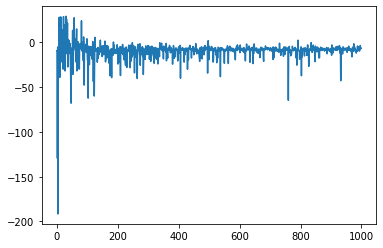

In [ ]:
plt.plot(env.world.evaders[0].rewards)

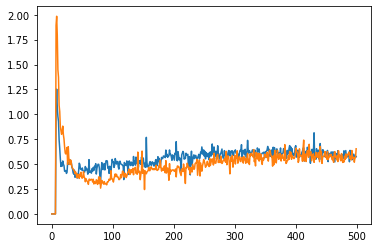

In [ ]:
plt.plot(env.world.pursuers[0].losses)
plt.plot(env.world.pursuers[1].losses)

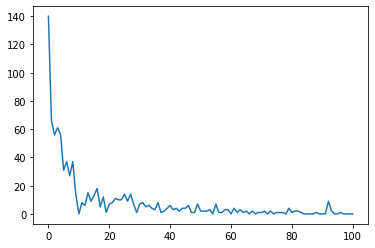

In [ ]:
violations_p = [sum(total_violations_p[i:i+10]) for i in range(0, len(total_violations_p),10)]
plt.plot(violations_p)

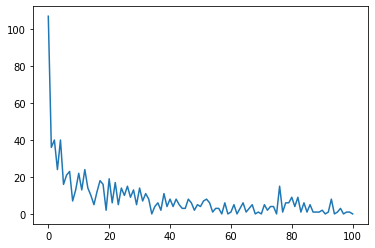

In [ ]:
violations_e = [sum(total_violations_e[i:i+10]) for i in range(0, len(total_violations_e),10)]
plt.plot(violations_e)